## This is the softmax workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement a softmax classifier.

Please print out the workbook entirely when completed.

The goal of this workbook is to give you experience with training a softmax classifier.

In [131]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'C:/Users/natha/OneDrive/Documents/School/UCLA/ECE C147/HW2_Code/hw2_Questions/code/cifar-10-batches-py' # You need to update this line
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Training a softmax classifier.

The following cells will take you through building a softmax classifier.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [133]:
from nndl import Softmax

In [134]:
# Declare an instance of the Softmax class.  
# Weights are initialized to a random value.
# Note, to keep people's first solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

softmax = Softmax(dims=[num_classes, num_features])

#### Softmax loss

In [135]:
## Implement the loss function of the softmax using a for loop over
#  the number of examples

loss = softmax.loss(X_train, y_train)

In [136]:
print(loss)

2.3277607028048966


## Question: 

You'll notice the loss returned by the softmax is about 2.3 (if implemented correctly).  Why does this make sense?

## Answer:

The weights are very small, so the loss is small

#### Softmax gradient

In [166]:
## Calculate the gradient of the softmax loss in the Softmax class.
# For convenience, we'll write one function that computes the loss
#   and gradient together, softmax.loss_and_grad(X, y)
# You may copy and paste your loss code from softmax.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = softmax.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a gradient check we wrote. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
softmax.grad_check_sparse(X_dev, y_dev, grad)

numerical: -1.254958 analytic: -1.254958, relative error: 3.829945e-08
numerical: -0.367224 analytic: -0.367224, relative error: 1.002945e-08
numerical: 2.035592 analytic: 2.035591, relative error: 2.471249e-08
numerical: -0.750471 analytic: -0.750471, relative error: 7.458235e-09
numerical: 3.088755 analytic: 3.088755, relative error: 2.644076e-08
numerical: 1.751307 analytic: 1.751307, relative error: 1.947506e-09
numerical: 3.422172 analytic: 3.422172, relative error: 1.005378e-08
numerical: -1.503132 analytic: -1.503132, relative error: 4.068083e-09
numerical: 0.644571 analytic: 0.644571, relative error: 3.027432e-08
numerical: 0.713086 analytic: 0.713086, relative error: 1.171041e-07


## A vectorized version of Softmax

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [138]:
import time

In [165]:
## Implement softmax.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = softmax.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} /{} '.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output.

Normal loss / grad_norm: 2.3356729000351644 / 342.9082958111227 computed in 0.08429551124572754s
Vectorized loss / grad: 2.3356729000351626 / 342.9082958111227 computed in 0.002874612808227539s
difference in loss / grad: 1.7763568394002505e-15 /2.257377580567496e-13 


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

iteration 0 / 1500: loss 2.3758786492109882
iteration 100 / 1500: loss 2.0145085883211458
iteration 200 / 1500: loss 1.9924377703374727
iteration 300 / 1500: loss 1.8874948914138299
iteration 400 / 1500: loss 1.9225327295416739
iteration 500 / 1500: loss 1.9339112895930348
iteration 600 / 1500: loss 1.9457904317181558
iteration 700 / 1500: loss 1.8454755955347795
iteration 800 / 1500: loss 1.866316724642826
iteration 900 / 1500: loss 1.9065910093872458
iteration 1000 / 1500: loss 1.8664644612671464
iteration 1100 / 1500: loss 1.846607048339252
iteration 1200 / 1500: loss 1.752835147935868
iteration 1300 / 1500: loss 1.8047816314467904
iteration 1400 / 1500: loss 1.8541799181072616
That took 5.544267654418945s


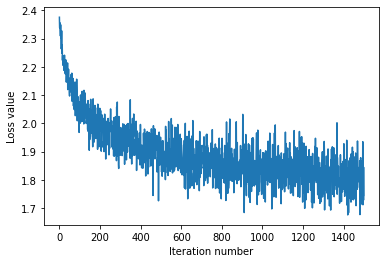

In [171]:
# Implement softmax.train() by filling in the code to extract a batch of data
# and perform the gradient step.
import time


tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained softmax classifier on the validation data.

In [172]:
## Implement softmax.predict() and use it to compute the training and testing error.

y_train_pred = softmax.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.3799387755102041
validation accuracy: 0.383


## Optimize the softmax classifier

In [173]:
np.finfo(float).eps

2.220446049250313e-16

In [179]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the Softmax classifier with different learning rates and 
#     evaluate on the validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best validation accuracy corresponding to the best validation error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
# ================================================================ #
train = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
accuracy = np.zeros_like(train)
for i in np.arange(len(train)):
    loss_hist = softmax.train(X_train, y_train, learning_rate=train[i],
                        num_iters=1500, verbose=False)
    y_train_pred = softmax.predict(X_train)
    accuracy[i] = np.mean(np.equal(y_train,y_train_pred), )
    print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
    
    

print("The best learning rate is: " + str(train[np.argmax(accuracy)]) + " with an accuracy of " + str(max(accuracy)))
# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


training accuracy: 0.26816326530612244
training accuracy: 0.36087755102040814
training accuracy: 0.42144897959183675
training accuracy: 0.37987755102040816
training accuracy: 0.2903877551020408
training accuracy: 0.1576530612244898
training accuracy: 0.09346938775510204
The best learning rate is: 1e-06 with an accuracy of 0.42144897959183675
